In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

def load_data(file_path):
    df = pd.read_csv(file_path)
    # Convert 'text' column to string type
    df['text'] = df['text'].astype(str)
    return df['text'].values, df['label'].values

def preprocess_data(texts, labels, max_words=90000, max_len=150):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    y = np.array(labels)
    return X, y, tokenizer

def create_model(max_words, max_len, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def train_model(X_train, y_train, X_val, y_val, model, epochs=10, batch_size=64):
    checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[checkpoint])
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    class_report = classification_report(y_test, y_pred_classes)

    return accuracy, conf_matrix, class_report

def export_model(model, tokenizer, file_path):
    model.save(file_path)
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_exported_model(model_path, tokenizer_path):
    model = load_model(model_path)
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    return model, tokenizer

def predict(text, model, tokenizer, max_len=100):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, prediction

if __name__ == "__main__":
    # Load and preprocess data
    texts, labels = load_data('./dataset/unique_data.csv')
    # X, y, tokenizer = preprocess_data(texts, labels)

    # Count labels 0 and 1
    label_counts = np.bincount(labels)
    print(f"Label 0 count: {label_counts[0]}")
    print(f"Label 1 count: {label_counts[1]}")

    # Preprocess the balanced data
    X, y, tokenizer = preprocess_data(texts, labels)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create and train the model
    model = create_model(max_words=90000, max_len=150)
    history = train_model(X_train, y_train, X_val, y_val, model)
    
    # Evaluate the model
    accuracy, conf_matrix, class_report = evaluate_model(model, X_test, y_test)
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Export the model
    export_model(model, tokenizer, 'sentiment_model.keras')

Label 0 count: 254549
Label 1 count: 71961


e:\TOOLS\MyProjets\api_python\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 662s 201ms/step - accuracy: 0.8803 - loss: 0.2871 - val_accuracy: 0.9091 - val_loss: 0.2214
Epoch 2/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 619s 189ms/step - accuracy: 0.9194 - loss: 0.2026 - val_accuracy: 0.9097 - val_loss: 0.2194
Epoch 3/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 640s 196ms/step - accuracy: 0.9285 - loss: 0.1821 - val_accuracy: 0.9093 - val_loss: 0.2230
Epoch 4/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 645s 198ms/step - accuracy: 0.9356 - loss: 0.1653 - val_accuracy: 0.9094 - val_loss: 0.2335
Epoch 5/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 642s 197ms/step - accuracy: 0.9418 - loss: 0.1492 - val_accuracy: 0.9070 - val_loss: 0.2464
Epoch 6/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 646s 198ms/step - accuracy: 0.9492 - loss: 0.1317 - val_accuracy: 0.9037 - val_loss: 0.2572
Epoch 7/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 659s 202ms/step - accuracy: 0.9553 - loss: 0.1181 - val_accuracy: 0.9042 - val_loss: 0.2935
Epoch 8/10
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 731s 224ms/step - ac

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle

def load_data(file_path):
    df = pd.read_csv(file_path)
    # Convert 'text' column to string type
    df['text'] = df['text'].astype(str)
    return df['text'].values, df['label'].values

def preprocess_data(texts, labels, max_words=90000, max_len=150):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    y = np.array(labels)
    return X, y, tokenizer

def create_model(max_words, max_len, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def train_model(X_train, y_train, X_val, y_val, model, epochs=10, batch_size=128):
    checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',   # Theo dõi mất mát
        factor=0.1,           # Giảm learning rate xuống 10 lần
        patience=2            # Chờ 2 epoch không cải thiện
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',   # Theo dõi mất mát trên tập validation
        patience=2,           # Dừng nếu không cải thiện sau 2 epoch
        restore_best_weights=True  # Phục hồi trọng số tốt nhất
    )
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping,checkpoint,reduce_lr])
    
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    class_report = classification_report(y_test, y_pred_classes)

    return accuracy, conf_matrix, class_report

def export_model(model, tokenizer, file_path):
    model.save(file_path)
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_exported_model(model_path, tokenizer_path):
    model = load_model(model_path)
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    return model, tokenizer

def predict(text, model, tokenizer, max_len=100):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, prediction

if __name__ == "__main__":
    # Load and preprocess data
    texts, labels = load_data('./dataset/unique_data.csv')
    # X, y, tokenizer = preprocess_data(texts, labels)

    # Count labels 0 and 1
    label_counts = np.bincount(labels)
    print(f"Label 0 count: {label_counts[0]}")
    print(f"Label 1 count: {label_counts[1]}")

    # Preprocess the balanced data
    X, y, tokenizer = preprocess_data(texts, labels)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create and train the model
    model = create_model(max_words=90000, max_len=150)
    history = train_model(X_train, y_train, X_val, y_val, model)
    
    # Evaluate the model
    accuracy, conf_matrix, class_report = evaluate_model(model, X_test, y_test)
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Export the model
    export_model(model, tokenizer, 'sentiment_model.keras')

Label 0 count: 254549
Label 1 count: 71961


e:\TOOLS\MyProjets\api_python\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 890s 541ms/step - accuracy: 0.8706 - loss: 0.3048 - val_accuracy: 0.9056 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 2/10
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 834s 511ms/step - accuracy: 0.9168 - loss: 0.2093 - val_accuracy: 0.9092 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 3/10
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 797s 488ms/step - accuracy: 0.9260 - loss: 0.1866 - val_accuracy: 0.9101 - val_loss: 0.2209 - learning_rate: 0.0010
Epoch 4/10
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 750s 460ms/step - accuracy: 0.9334 - loss: 0.1706 - val_accuracy: 0.9101 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 5/10
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 733s 449ms/step - accuracy: 0.9406 - loss: 0.1542 - val_accuracy: 0.9064 - val_loss: 0.2365 - learning_rate: 0.0010
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step
Accuracy: 0.9073075862913846
Confusion Matrix:
[[48037  2777]
 [ 3276 11212]]
Classification Report:
              precision    recall  f1-score   support

         

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE

import pickle

def load_data(file_path):
    df = pd.read_csv(file_path)
    # Convert 'text' column to string type
    df['text'] = df['text'].astype(str)
    return df['text'].values, df['label'].values

def preprocess_data(texts, labels, max_words=90000, max_len=150):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    y = np.array(labels)
    return X, y, tokenizer

def create_model(max_words, max_len, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(X_train, y_train, X_val, y_val, model, epochs=10, batch_size=128):
    checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',   # Theo dõi mất mát
        factor=0.1,           # Giảm learning rate xuống 10 lần
        patience=2            # Chờ 2 epoch không cải thiện
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',   # Theo dõi mất mát trên tập validation
        patience=2,           # Dừng nếu không cải thiện sau 2 epoch
        restore_best_weights=True  # Phục hồi trọng số tốt nhất
    )
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping,checkpoint,reduce_lr])
    
    return history

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    class_report = classification_report(y_test, y_pred_classes)

    return accuracy, conf_matrix, class_report

def export_model(model, tokenizer, file_path):
    model.save(file_path)
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_exported_model(model_path, tokenizer_path):
    model = load_model(model_path)
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    return model, tokenizer

def predict(text, model, tokenizer, max_len=100):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return sentiment, prediction

if __name__ == "__main__":
    # Load and preprocess data
    texts, labels = load_data('./dataset/unique_data.csv')
    # X, y, tokenizer = preprocess_data(texts, labels)

    # Count labels 0 and 1
    label_counts = np.bincount(labels)
    print(f"Label 0 count: {label_counts[0]}")
    print(f"Label 1 count: {label_counts[1]}")

    # Preprocess the balanced data
    X, y, tokenizer = preprocess_data(texts, labels)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


    # # Áp dụng SMOTE để xử lý mất cân bằng dữ liệu
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Create and train the model
    model = create_model(max_words=90000, max_len=150)
    history = train_model(X_train_smote, y_train_smote, X_val, y_val, model)
    
    # Evaluate the model
    accuracy, conf_matrix, class_report = evaluate_model(model, X_test, y_test)
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Export the model
    export_model(model, tokenizer, 'sentiment_model.keras')

Label 0 count: 254549
Label 1 count: 71961


e:\TOOLS\MyProjets\api_python\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 1180s 461ms/step - accuracy: 0.8175 - loss: 0.3817 - val_accuracy: 0.8933 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 2/10
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 1177s 462ms/step - accuracy: 0.9350 - loss: 0.1649 - val_accuracy: 0.9009 - val_loss: 0.2460 - learning_rate: 0.0010
Epoch 3/10
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 1356s 532ms/step - accuracy: 0.9466 - loss: 0.1379 - val_accuracy: 0.9008 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 4/10
2548/2548 ━━━━━━━━━━━━━━━━━━━━ 1411s 554ms/step - accuracy: 0.9537 - loss: 0.1196 - val_accuracy: 0.8982 - val_loss: 0.2649 - learning_rate: 0.0010
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 48s 23ms/step
Accuracy: 0.8979051177605586
Confusion Matrix:
[[47419  3395]
 [ 3272 11216]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     50814
           1       0.77      0.77      0.77     14488

    accuracy                           0.90     65302


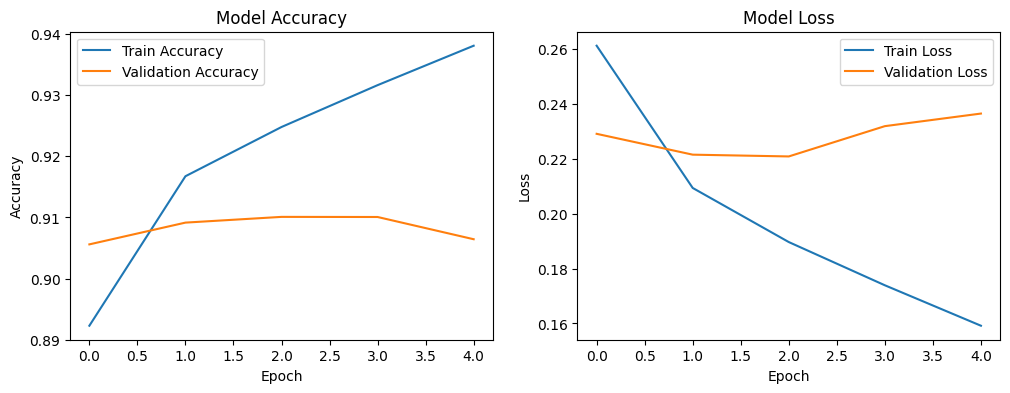

In [3]:
import matplotlib.pyplot as plt

# Plot accuracy history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
import pickle

def sentiment_pipeline(
    file_path, 
    max_words=90000, 
    max_len=150, 
    embedding_dim=100, 
    epochs=10, 
    batch_size=64, 
    model_path='sentiment_model.keras', 
    tokenizer_path='tokenizer.pickle'
):
    # 1. Load data
    df = pd.read_csv(file_path)
    df['text'] = df['text'].astype(str)
    texts, labels = df['text'].values, df['label'].values
    
    # 2. Preprocess data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    y = np.array(labels)
    
    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # 4. Handle imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # 5. Create model
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM layer
        Dropout(0.3),  # Dropout layer to reduce overfitting
        Bidirectional(LSTM(32)),  # Another Bidirectional LSTM layer
        Dropout(0.2),  # Dropout layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 6. Train model
    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(
        X_train_smote, y_train_smote, 
        epochs=epochs, batch_size=batch_size, 
        validation_data=(X_val, y_val), 
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    # 7. Evaluate model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    class_report = classification_report(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # 8. Save model and tokenizer
    model.save(model_path)
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Model and tokenizer saved successfully!")

# Example usage:
sentiment_pipeline('./dataset/unique_data.csv')

e:\TOOLS\MyProjets\api_python\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 968s 188ms/step - accuracy: 0.8416 - loss: 0.3422 - val_accuracy: 0.8963 - val_loss: 0.2516 - learning_rate: 0.0010
Epoch 2/10
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 907s 178ms/step - accuracy: 0.9361 - loss: 0.1609 - val_accuracy: 0.9018 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 3/10
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 932s 183ms/step - accuracy: 0.9474 - loss: 0.1339 - val_accuracy: 0.9028 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 4/10
5096/5096 ━━━━━━━━━━━━━━━━━━━━ 944s 185ms/step - accuracy: 0.9544 - loss: 0.1176 - val_accuracy: 0.9001 - val_loss: 0.2628 - learning_rate: 0.0010
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step
Accuracy: 0.8985329698937246
Confusion Matrix:
[[47046  3768]
 [ 2858 11630]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     50814
           1       0.76      0.80      0.78     14488

    accuracy                           0.90     65302
   m

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
import pickle

def sentiment_pipeline(
    file_path, 
    max_words=90000, 
    max_len=150, 
    embedding_dim=100, 
    epochs=10, 
    batch_size=32, 
    model_path='sentiment_model.keras', 
    tokenizer_path='tokenizer.pickle'
):
    # 1. Load data
    df = pd.read_csv(file_path)
    df['text'] = df['text'].astype(str)
    texts, labels = df['text'].values, df['label'].values
    
    # 2. Preprocess data
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len)
    y = np.array(labels)
    
    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # 4. Handle imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # 5. Create model
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM layer
        Dropout(0.5),  # Dropout layer to reduce overfitting
        Bidirectional(LSTM(32)),  # Another Bidirectional LSTM layer
        Dropout(0.5),  # Dropout layer
        Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 6. Train model
    checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(
        X_train_smote, y_train_smote, 
        epochs=epochs, batch_size=batch_size, 
        validation_data=(X_val, y_val), 
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    # 7. Evaluate model
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    class_report = classification_report(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # 8. Save model and tokenizer
    model.save(model_path)
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Model and tokenizer saved successfully!")

# Example usage:
sentiment_pipeline('./dataset/unique_data.csv')

e:\TOOLS\MyProjets\api_python\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
10175/10175 ━━━━━━━━━━━━━━━━━━━━ 2265s 218ms/step - accuracy: 0.8503 - loss: 0.3286 - val_accuracy: 0.8956 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 2/10
10175/10175 ━━━━━━━━━━━━━━━━━━━━ 2063s 203ms/step - accuracy: 0.9361 - loss: 0.1639 - val_accuracy: 0.9059 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 3/10
10175/10175 ━━━━━━━━━━━━━━━━━━━━ 2097s 206ms/step - accuracy: 0.9461 - loss: 0.1399 - val_accuracy: 0.9029 - val_loss: 0.2471 - learning_rate: 0.0010
Epoch 4/10
 3177/10175 ━━━━━━━━━━━━━━━━━━━━ 24:04 206ms/step - accuracy: 0.9546 - loss: 0.1192